### Lab3 - Kompresja macierzy (Jan Masternak, Jakub Mróz):

#### Kwestie techniczne:

* Pomiary wykonywane na procesorze i5-13400f będą miały przed bezpośrednio przed rozszerzeniem końcówkę "...i5_13400f"

##### Importy potrzebnych paczek:

Poniższe wystarczy uruchomić jeden raz.

In [ ]:
using Pkg
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("Plots")
# Pkg.add("LinearAlgebra")
# Pkg.add("LaTeXStrings")
# Pkg.add("StatsPlots")
# Pkg.add("TSVD")
# Pkg.add("Images")
# Pkg.add("ImageIO")
# Pkg.add("ColorTypes")
# Pkg.add("ImageView")
# Pkg.add("Adapt");

   Resolving package versions...
    Updating `C:\Users\Jan\.julia\environments\v1.10\Project.toml`
  [79e6a3ab] + Adapt v4.1.1
  No Changes to `C:\Users\Jan\.julia\environments\v1.10\Manifest.toml`


Poniższe uruchamiamy każdorazowo.

In [ ]:
using CSV
using DataFrames
using Plots
using LinearAlgebra
using LaTeXStrings
using StatsPlots
using TSVD
using Images
using ImageIO
using ColorTypes
using ImageView
using Adapt;

In [43]:
cpu = "i5_13400f"
error_eps = 1e-8;

In [44]:
function generate_random_matrix(m, n, a, b)
    A = zeros(m, n)
    for i in 1:1:m 
        for j in 1:1:n 
            A[i,j] = a + (b-a)*rand()
        end
    end
    return A
end

function are_equal(A, B)
    if !all(size(A) .== size(B))
        return false
    end

    return all(abs.(A-B) .< error_eps)

end

function pad(A, target_rows, target_cols)
    rows, cols = A.size()
    return [A zeros(rows, target_cols-cols) ; zeros(target_rows-rows, target_cols)]
end;

##### Ładowanie bitmap:

In [45]:
abstract1 = load("bitmaps/abstract1.bmp");

##### Display bitmap:

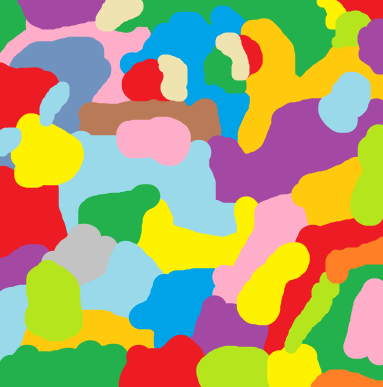

In [46]:
abstract1

##### Tworzenie tablic RGB dla bitmap:

In [47]:
function from_1_to_255_RGB_repr(x::Float64)
    return 255*x
end

function from_255_to_1_RGB_repr(x::Float64)
    return x/255
end;

In [48]:
abstract1_rows, abstract1_cols = size(abstract1)
abstract1R, abstract1G, abstract1B = zeros(abstract1_rows, abstract1_cols), zeros(abstract1_rows, abstract1_cols), zeros(abstract1_rows, abstract1_cols)

for i in 1:1:abstract1_rows
    for j in 1:1:abstract1_cols
        pixel_ij = abstract1[i,j]
        abstract1R[i,j] = red(pixel_ij)
        abstract1G[i,j] = green(pixel_ij)
        abstract1B[i,j] = blue(pixel_ij)
    end
end

##### Sprawdzenie poprawności działania tworzenia tablic RGB:

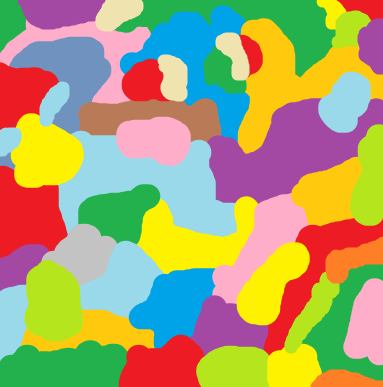

In [49]:
built_abstract1 = colorview(RGB, abstract1R, abstract1G, abstract1B)
save("bitmaps/built_abstract1.bmp", built_abstract1)
img_built_abstract1 = load("bitmaps/built_abstract1.bmp")

### Tworzenie macierzy kompresji z użyciem truncated SVD:

##### Konwersja macierzy R, G, B z przedziału 1.0 na 255:

In [50]:
abstract1R_255, abstract1G_255, abstract1B_255 = deepcopy(abstract1R), deepcopy(abstract1G), deepcopy(abstract1B)
abstract1R_255 = from_1_to_255_RGB_repr.(abstract1R_255)
abstract1G_255 = from_1_to_255_RGB_repr.(abstract1G_255)
abstract1G_255 = from_1_to_255_RGB_repr.(abstract1G_255)

387×383 Matrix{Float64}:
 45135.0  45135.0  45135.0  45135.0  …   7140.0   7140.0   7140.0   7140.0
 45135.0  45135.0  45135.0  45135.0      7140.0   7140.0   7140.0   7140.0
 45135.0  45135.0  45135.0  45135.0      7140.0   7140.0   7140.0   7140.0
 45135.0  45135.0  45135.0  45135.0      7140.0   7140.0   7140.0   7140.0
 45135.0  45135.0  45135.0  45135.0      7140.0   7140.0   7140.0   7140.0
 45135.0  45135.0  45135.0  45135.0  …   7140.0   7140.0   7140.0   7140.0
 45135.0  45135.0  45135.0  45135.0      7140.0   7140.0   7140.0   7140.0
 45135.0  45135.0  45135.0  45135.0      7140.0   7140.0   7140.0   7140.0
 45135.0  45135.0  45135.0  45135.0      7140.0   7140.0   7140.0   7140.0
 45135.0  45135.0  45135.0  45135.0      7140.0   7140.0   7140.0   7140.0
     ⋮                               ⋱               ⋮             
 45135.0  45135.0  45135.0  45135.0     45135.0  45135.0  45135.0  45135.0
 45135.0  45135.0  45135.0  45135.0     45135.0  45135.0  45135.0  45135.0
 45135.

##### Kompresja macierzy z użyciem truncated SVD:

In [58]:
module CompressionTreeModule

mutable struct CompressionTreeNode
    rank
    addr

    left_upper_child
    right_upper_child
    left_lower_child
    right_lower_child

    singular_values
    U_matrix
    V_matrix
end

function create_empty_compr_tree_node()
    return CompressionTreeNode(nothing, nothing, 
                               nothing, nothing, nothing, nothing,
                               nothing, nothing, nothing)
end

end;

using .CompressionTreeModule;

In [59]:
function compress_matrix(A, r_min, r_max, c_min, c_max, U, D, V, gamma)
    if all(abs.(A[r_min:r_max , col_min:col_max]) .< error_eps)
        v = create_empty_compr_tree_node()
        v.rank = 0
        v.addr = (r_min, r_max, c_min, c_max)
        return v
    else
        sigmas = diag(D)
        v = create_empty_compr_tree_node()
        v.rank = gamma
        v.addr = (r_min, r_max, c_min, c_max)
        v.singular_values = sigmas[1:gamma]
        v.U_matrix = U[: , 1:gamma]
        v.V_matrix = D[1:gamma , 1:gamma] * V[1:gamma , :]
        return v
    end
end;

In [60]:
function create_tree(A, r_min, r_max, c_min, c_max, gamma, eps)
    println(size(A))
    println("")
    if r_min == r_max && c_min == c_max
        v = create_empty_compr_tree_node()
        v.rank = 1
        v.addr = (r_min, r_max, c_min, c_max)
        v.U_matrix = A[r_min, c_min]
        println(size(A))
        println(v)
        println("")
        return v
    end   
    
    U, D, V = tsvd(A[r_min:r_max , c_min:c_max], gamma+1)
    if D[gamma+1, gamma+1] - eps < error_eps
        v = compress_matrix(A, r_min, r_max, c_min, c_max, U, D, V, gamma)
        println(size(A))
        println(v)
        println("")
        return v
    end 
    
    r_mid = div(r_min+r_max,2)
    c_mid = div(c_min+c_max,2)
    right_upper_child, left_lower_child, right_lower_child = nothing, nothing, nothing
    left_upper_child = create_tree(A, r_min, r_mid, c_min, c_mid, gamma, eps)
    if c_mid < c_max
        right_upper_child = create_tree(A, r_min, r_mid, c_mid+1, c_max, gamma, eps)
    end
    if r_mid < r_max
        left_lower_child = create_tree(A, r_mid+1, r_max, c_min, c_mid, gamma, eps)
        if c_mid < c_max
            right_lower_child = create_tree(A, r_mid+1, r_max, c_mid+1, c_max, gamma, eps)
        end            
    end

    v = create_empty_compr_tree_node()
    v.addr = (r_min, r_max, c_min, c_max)
    v.left_upper_child = left_upper_child
    v.right_upper_child = right_upper_child
    v.left_lower_child = left_lower_child
    v.right_lower_child = right_upper_child
    println(size(A))
    println(v)
    println("")

    return v

end;

##### Testowanie kompresji macierzy z TSVD:

Poniżej przetestowano poprawne działanie zaimplementowanego algorytmu dla losowych danych - ta sekcja jeszcze nie ma nic stricte wspólnego z kompresją bitampy.

In [61]:
function build_matrix_based_on_tree(node)
    r_min, r_max, c_min, c_max = node.addr
    A = zeros(r_max-r_min+1, c_max-c_min+1)
    
    if !isnothing(node.rank) && node.rank == 0
        return A  
    elseif !isnothing(node.U_matrix)
        if !isnothing(node.V_matrix)
            return pad(node.U_matrix*node.V_matrix, r_max-r_min+1, c_max-c_min+1)
        else 
            return pad(node.U_matrix, r_max-r_min+1, c_max-c_min+1)   
        end
    end 

    r_mid = div(r_max+r_mid,2)
    c_mid = div(c_max+c_min,2)
    A[r_min:r_mid , c_min:c_mid] += build_matrix_based_on_tree(A.left_upper_child)
    if !isnothing(A.right_upper_child)
        A[r:min:r_mid , c_mid+1:c_max] += build_matrix_based_on_tree(A.right_upper_child)
    end
    if !isnothing(A.left_lower_child)
        A[r:mid+1:r_max , c_min:c_mid] += build_matrix_based_on_tree(A.left_lower_child)
    end
    if !isnothing(A.right_lower_child)
        A[r:mid+1:r_max , c_mid+1:c_max] += build_matrix_based_on_tree(A.right_lower_child)
    end

    return A
end;

In [62]:
function test_matrix_compression(low_m, high_m, low_n, high_n, a, b, tests, gamma, eps)
    correct_outputs = 0
    incorrect_ouputs = 0
    for _ in 1:1:tests 
        A = generate_random_matrix(rand(low_m:1:high_m), rand(low_n:1:high_n), a, b)
        tree_root = create_tree(A, 1, size(A,1), 1, size(A,2), gamma, eps)
        built_A = build_matrix_based_on_tree(tree_root)
        if are_equal(A, built_A)
            correct_outputs += 1
        else 
            incorrect_ouputs += 1    
        end
    end

    return correct_outputs, incorrect_ouputs
end;

In [56]:
low_m_for_test, high_m_for_test, low_n_for_test, high_n_for_test = 1, 10, 1, 10
a_for_test, b_for_test = 0, 50
correct, incorrect = test_matrix_compression(low_m_for_test, high_m_for_test, low_n_for_test, high_n_for_test, a_for_test, b_for_test, 15, 1, 0.1)
println(correct, incorrect);

(1, 4)



LAPACKException: LAPACKException(2)